## ANALISIS DE REGRESION LOGÌSTICA

###  Librerías a utilizar

In [163]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn import metrics

### Base de datos

In [164]:
path_file = r'D:/OneDrive - Universidad Peruana de Ciencias/Documents/Carrera/2023-1/Fundamentos Data Science/Data-Science-Python/Reg_Logística/'

In [165]:
df = pd.read_csv(path_file + 'BD_Loan.csv', delimiter= ',')
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [166]:
# Estructura de los datos
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [167]:
# Cantidad de los datos
df.shape

(614, 13)

In [168]:
## Validamos el número de clientes únicos en la base
len(df.Loan_ID.unique())

614

### Exploraciòn de la data

#### Funciones

In [169]:
## Calcula los porcentajes de missings por variable

def fx_porc_missings(data, only_missings = False):

    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings) 

In [170]:
## Estructura de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [171]:
# Número de datos ausentes por variable
# ==============================================================================
df.isna().sum().sort_values()

Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
Married               3
Gender               13
Loan_Amount_Term     14
Dependents           15
LoanAmount           22
Self_Employed        32
Credit_History       50
dtype: int64

#### Variable Objetivo

In [172]:
# Frecuencia de la variable objetivo
df.Loan_Status.value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [173]:
df.Loan_Status.value_counts()/df.shape[0]

Loan_Status
Y    0.687296
N    0.312704
Name: count, dtype: float64

In [174]:
## Convertir variable
df['Target'] = df['Loan_Status'].replace({'N': 0,'Y': 1})

In [175]:
df = df.drop(['Loan_Status'], axis = 1)

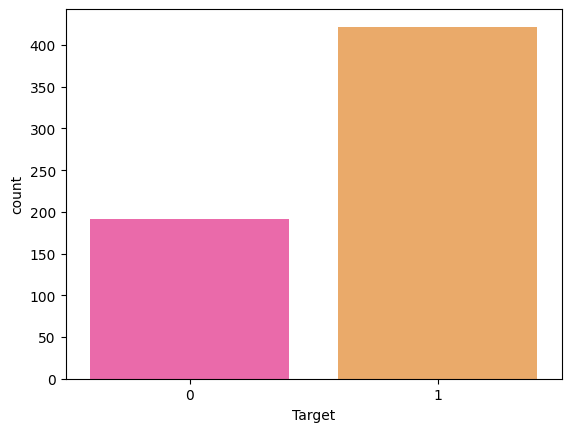

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x = 'Target', data=df, palette = 'spring')
plt.savefig('Numero_ventas.png', bbox_inches='tight')

In [177]:
# Guardamos los identificadores de cliente y los excluimos del análisis de variables
df_index = df[['Loan_ID','Target']]
df = df.drop(['Loan_ID'], axis = 1)

#### Variables numèricas

In [178]:
numericas= df.select_dtypes(include=['float64', 'int'])

In [179]:
# Variables numéricas
# ==============================================================================
# df.select_dtypes(include=['float64', 'int']).describe()
numericas.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Target
count,614.000000,614.000000,592.000000,600.00000,564.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199,0.687296
std,6109.041673,2926.248369,85.587325,65.12041,0.364878,0.463973
min,150.000000,0.000000,9.000000,12.00000,0.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000,0.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000,1.000000


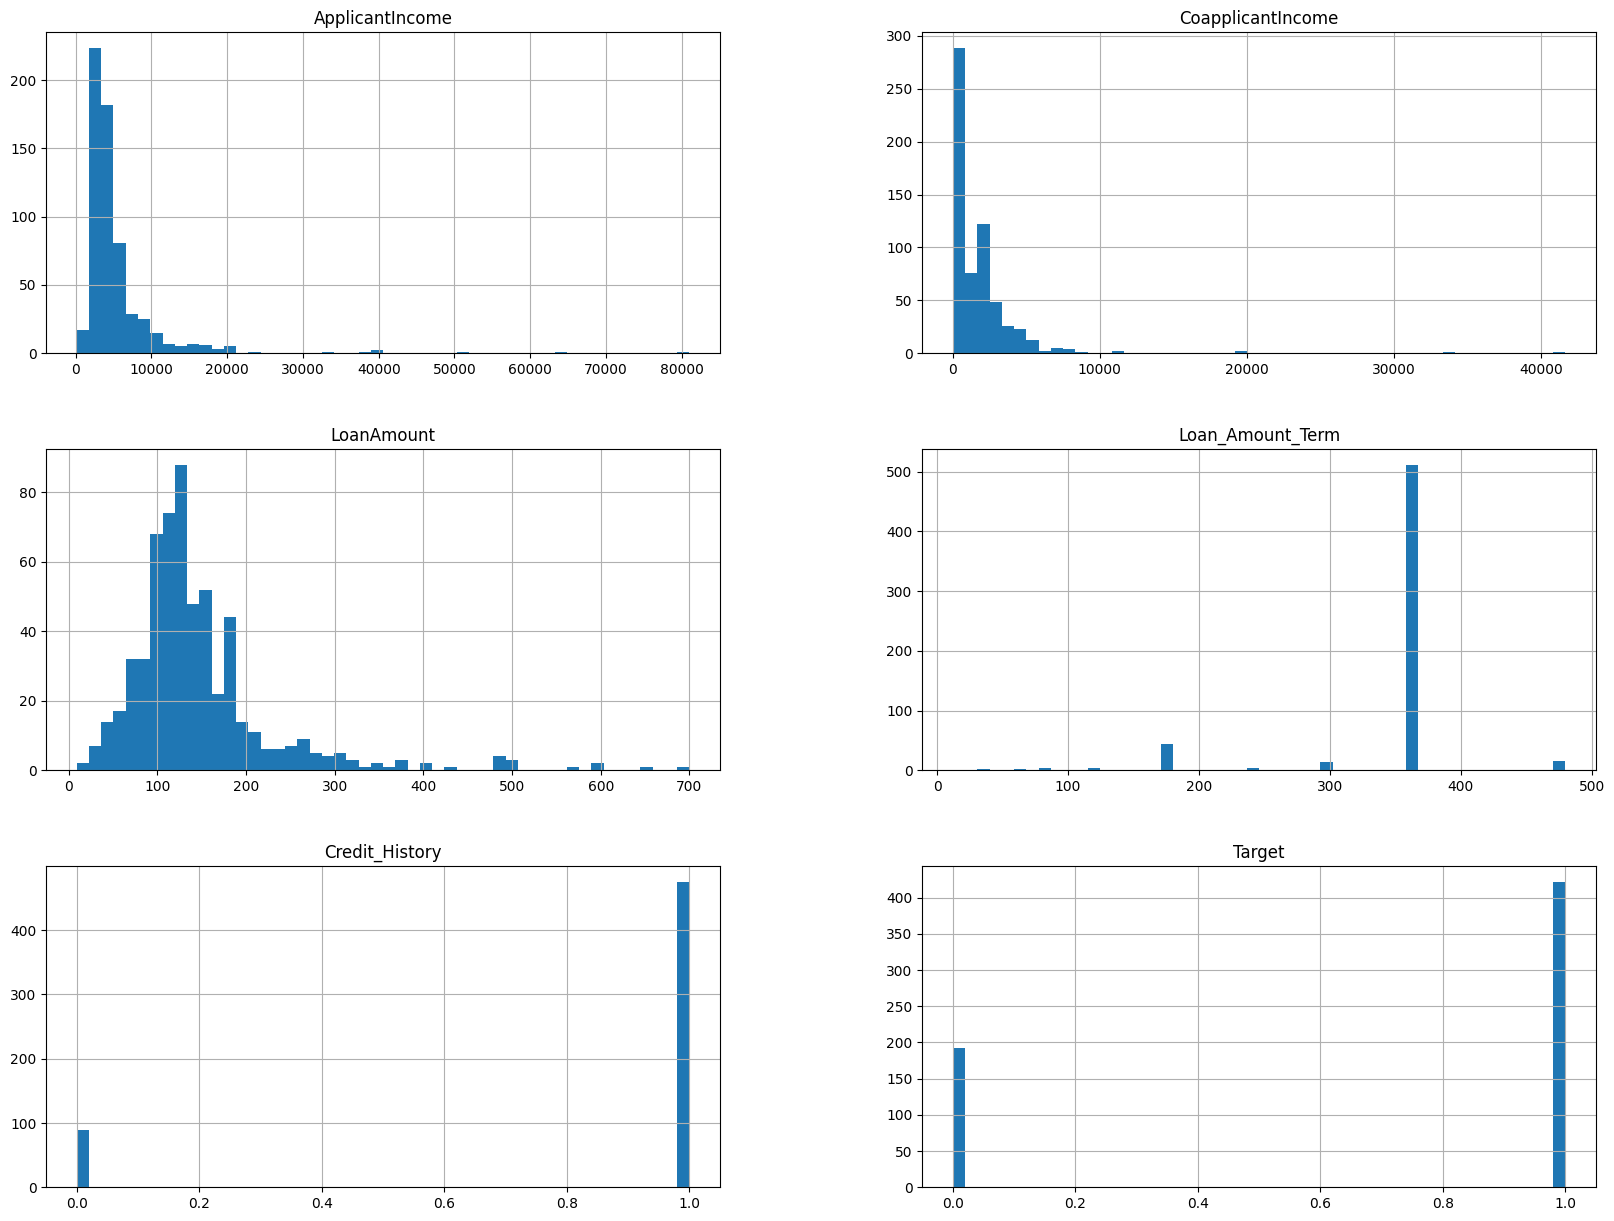

In [180]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
numericas.hist(bins=50,figsize=(20,15))
plt.show()

In [181]:
# Valores observados 
# ==============================================================================
df.Credit_History.value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

In [182]:
## Missing de Variables
variables_perdidos = fx_porc_missings(numericas, only_missings = True)    
#variables_perdidos.head()
variables_perdidos

,n_nulos,%Total
LoanAmount,22,3.583062
Loan_Amount_Term,14,2.280130
Credit_History,50,8.143322


In [183]:
#para la muestra se va considerr 60%
variables_perdidos[variables_perdidos['%Total'] > 60].index.tolist() 

[]

In [184]:
## Imputar con la mediana porque no es afectado por los valores atipicos
for column in numericas:
    df[column] = df[column].fillna(df[column].median()) 


In [185]:
# Se convierte la variable a tipo string
# ==============================================================================
df.Credit_History = df.Credit_History.astype("str")

#### Variables Cualitativas

In [186]:
categoricas = df.select_dtypes(include=['object','category'])

In [187]:
# Variables cualitativas (tipo object)
# ==============================================================================
categoricas.describe()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area
count,601,611,599,614,582,614,614
unique,2,2,4,2,2,2,3
top,Male,Yes,0,Graduate,No,1.0,Semiurban
freq,489,398,345,480,500,525,233


Text(0.5, 0.98, 'Distribución variables cualitativas')

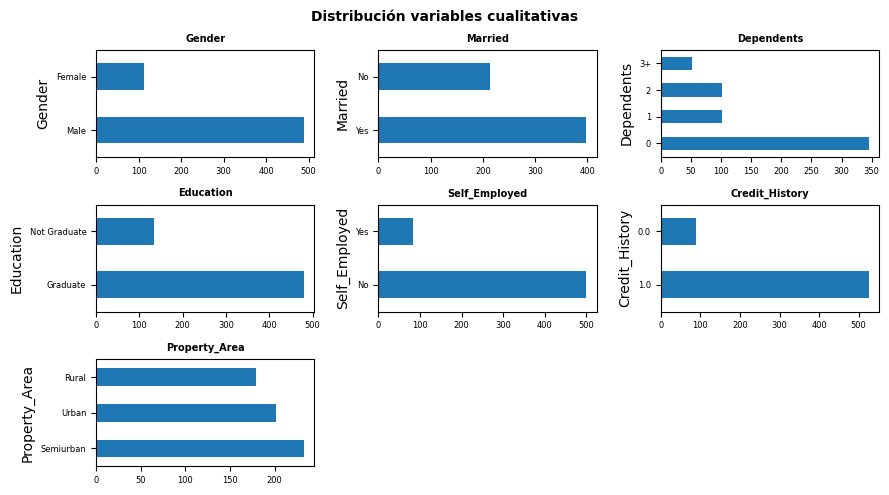

In [188]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    df[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold")

In [189]:
# Recodificando y convirtiendo las variables de acuerdo a nuestro criterio
df['Dependents'] = df['Dependents'].replace({'0': 1,'1': 2, '2': 3, '3+': 4})

In [190]:
## Missing de Variables
variables_perdidos = fx_porc_missings(categoricas, only_missings = True)    
#variables_perdidos.head()
variables_perdidos

,n_nulos,%Total
Gender,13,2.117264
Married,3,0.488599
Dependents,15,2.442997
Self_Employed,32,5.211726


In [191]:
#Imputar variables con la moda por ser categoricas
for column in categoricas:
    df[column] = df[column].fillna(df[column].mode()[0]) 

### Creación y Transformación de Variables

In [192]:
# Feature Engineering
# Creación de variables a partir de las definidas
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['LoanAmount_Log'] = round(np.log(df['LoanAmount']+1),2)
df['AmountxTerm']=round(df['LoanAmount']/df['Loan_Amount_Term'],2)

In [193]:
df.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Target,TotalIncome,LoanAmount_Log,AmountxTerm
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,1.744300,5403.459283,1621.245798,145.752443,342.410423,0.687296,7024.705081,4.866173,0.473844
std,1.009623,6109.041673,2926.248369,84.107233,64.428629,0.463973,6458.663872,0.491101,0.511007
min,1.000000,150.000000,0.000000,9.000000,12.000000,0.000000,1442.000000,2.300000,0.020000
25%,1.000000,2877.500000,0.000000,100.250000,360.000000,0.000000,4166.000000,4.620000,0.290000
50%,1.000000,3812.500000,1188.500000,128.000000,360.000000,1.000000,5416.500000,4.860000,0.360000
75%,2.000000,5795.000000,2297.250000,164.750000,360.000000,1.000000,7521.750000,5.110000,0.510000
max,4.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,81000.000000,6.550000,9.250000


In [194]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Target,TotalIncome,LoanAmount_Log,AmountxTerm
0,Male,No,1.0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,5849.0,4.86,0.36
1,Male,Yes,2.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,4.86,0.36
2,Male,Yes,1.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,4.20,0.18
3,Male,Yes,1.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,4.80,0.33
4,Male,No,1.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,4.96,0.39


#### Dataset Final

In [195]:
df_final=df

In [196]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    float64
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    object 
 10  Property_Area      614 non-null    object 
 11  Target             614 non-null    int64  
 12  TotalIncome        614 non-null    float64
 13  LoanAmount_Log     614 non-null    float64
 14  AmountxTerm        614 non-null    float64
dtypes: float64(7), int64(2), object(6)
memory usage: 72.1+ KB


## Modelado

Definición de variables: Independientes y Dependiente

In [197]:
X = df_final.drop(['Target'], axis = 1)

In [198]:
y= df_final.Target

In [199]:
categoricas = X.select_dtypes(include=('object','category')).columns.tolist()
numericas = X.select_dtypes(include=('int64','float64')).columns.tolist()

In [200]:
## Cantidad de Categorías por Variable
variables_str  = X.select_dtypes(include = ['object','category']).columns.tolist()
for var in variables_str:
    print('N de ', var,':',df_final[var].nunique())

N de  Gender : 2
N de  Married : 2
N de  Education : 2
N de  Self_Employed : 2
N de  Credit_History : 2
N de  Property_Area : 3


In [201]:
categorical=pd.get_dummies(X[categoricas],columns=categoricas,drop_first=True)
categorical.columns = ['Gender','Married','Education','Self_Employed', 'Credit_History','Property_Area_1','Property_Area_2']
categorical

,Gender,Married,Education,Self_Employed,Credit_History,Property_Area_1,Property_Area_2
0,True,False,False,False,True,False,True
1,True,True,False,False,True,False,False
2,True,True,False,True,True,False,True
3,True,True,True,False,True,False,True
4,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...
609,False,False,False,False,True,False,False
610,True,True,False,False,True,False,False
611,True,True,False,False,True,False,True
612,True,True,False,False,True,False,True


In [202]:
numerical = X[numericas]
numericas

['Dependents',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'TotalIncome',
 'LoanAmount_Log',
 'AmountxTerm']

In [203]:
preprocessed_data = pd.merge(numerical, categorical, left_index=True, right_index=True)
preprocessed_data.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,TotalIncome,LoanAmount_Log,AmountxTerm,Gender,Married,Education,Self_Employed,Credit_History,Property_Area_1,Property_Area_2
0,1.0,5849,0.0,128.0,360.0,5849.0,4.86,0.36,True,False,False,False,True,False,True
1,2.0,4583,1508.0,128.0,360.0,6091.0,4.86,0.36,True,True,False,False,True,False,False
2,1.0,3000,0.0,66.0,360.0,3000.0,4.20,0.18,True,True,False,True,True,False,True
3,1.0,2583,2358.0,120.0,360.0,4941.0,4.80,0.33,True,True,True,False,True,False,True
4,1.0,6000,0.0,141.0,360.0,6000.0,4.96,0.39,True,False,False,False,True,False,True


Dividiendo en Entrenamiento y Validación

In [204]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data,y,train_size = 0.8,random_state = 20,stratify = y)

#### Cross Validation - Selección Variables

In [205]:
# Declarar el modelo a usar
model_rf = RandomForestClassifier(n_estimators=50,  # Número de árboles en el bosque
                                 max_depth = 5,     # Profundidad máxima del árbol (hojas)
                                 random_state = 49, # Controla aleatoriedad del arranque de la muestra
                                 max_features = 30)

In [206]:
# Probar rendimiento del modelo
skf = StratifiedKFold(n_splits= 5,shuffle=True, random_state = 49)
cross_val = cross_val_score(cv = skf,
                           estimator = model_rf,
                           X=X_train,
                           y=y_train, 
                           scoring = 'accuracy') # 'auc_roc'

print("Todos los scores:",cross_val)
print("Promedio de los scores:",np.mean(cross_val))

Todos los scores: [0.78787879 0.84693878 0.74489796 0.82653061 0.78571429]
Promedio de los scores: 0.7983920841063697


Selección de Variables

In [207]:
# Entrenamiento
model_rf_all = model_rf.fit(X_train, y_train)

In [208]:
X_train.columns

Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'TotalIncome', 'LoanAmount_Log', 'AmountxTerm',
       'Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History',
       'Property_Area_1', 'Property_Area_2'],
      dtype='object')

In [209]:
#Importancia de las variables
features_rf = pd.DataFrame()
features_rf['variable'] = X_train.columns
features_rf['Importancia'] = model_rf_all.feature_importances_
features_rf.sort_values(by = ['Importancia'],ascending=False,inplace = True)
features_rf.head()

,variable,Importancia
12,Credit_History,0.602696
5,TotalIncome,0.095144
1,ApplicantIncome,0.063196
2,CoapplicantIncome,0.056300
7,AmountxTerm,0.054433


<Axes: xlabel='Importancia', ylabel='variable'>

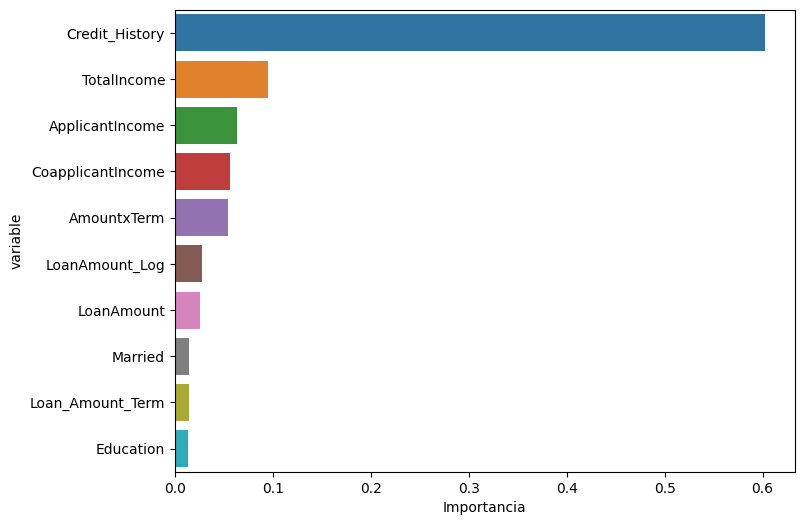

In [210]:
fig,ax = plt.subplots(1,1,figsize = (8,6))
sns.barplot(y='variable',x = 'Importancia',data = features_rf.head(10),
           order =features_rf.head(10)['variable'],
           ax=ax)

#### Correlación de Variables

In [211]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

In [212]:
corr_matrix = df_final.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
34,LoanAmount,LoanAmount_Log,0.898047,0.898047
66,LoanAmount_Log,LoanAmount,0.898047,0.898047
15,ApplicantIncome,TotalIncome,0.893037,0.893037
55,TotalIncome,ApplicantIncome,0.893037,0.893037
33,LoanAmount,TotalIncome,0.620316,0.620316
57,TotalIncome,LoanAmount,0.620316,0.620316
12,ApplicantIncome,LoanAmount,0.565181,0.565181
28,LoanAmount,ApplicantIncome,0.565181,0.565181
61,TotalIncome,LoanAmount_Log,0.507210,0.507210
69,LoanAmount_Log,TotalIncome,0.507210,0.507210


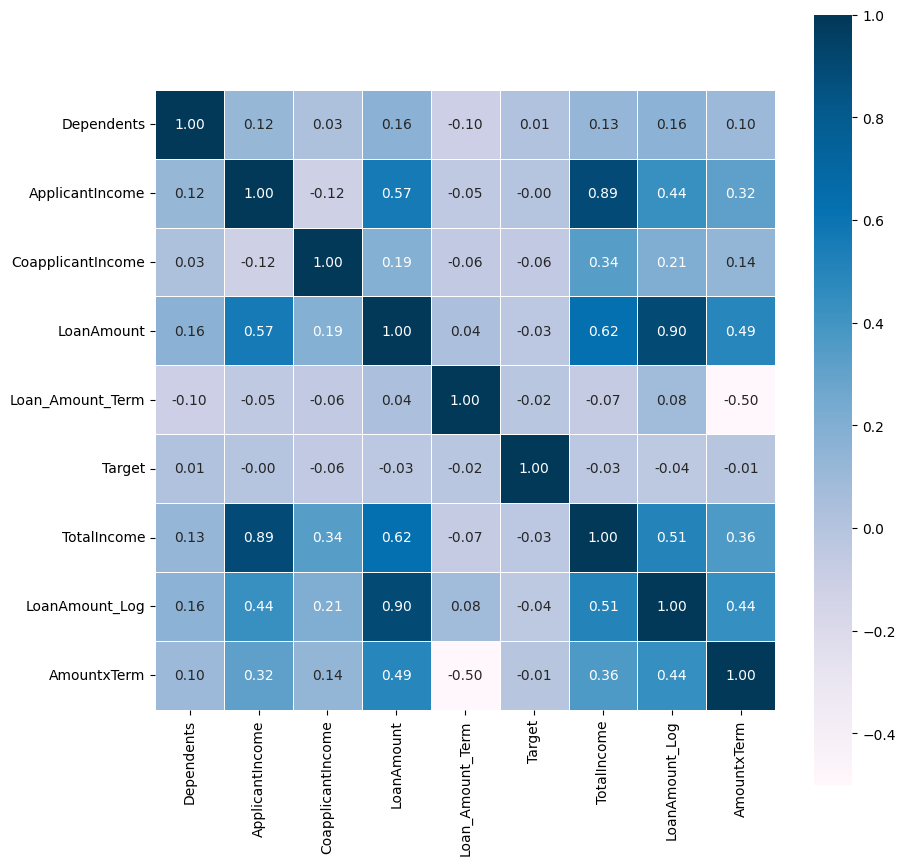

In [213]:
# Heatmap matriz de correlaciones
# ==============================================================================
corr = sns.heatmap(corr_matrix, 
                   vmax = 1, 
                   square = True, 
                   linewidth = 0.5, 
                   yticklabels = True, 
                   xticklabels = True, 
            cbar_kws = {'shrink' : 1}, 
                   annot = True, 
                   fmt = '.2f', 
                   cmap = 'PuBu')
corr.figure.set_size_inches(10,10)
# plt.savefig(path_outputs + 'Correlaciones.png', bbox_inches = 'tight') falta

Eliminamos Variables por alta correlación

In [214]:
df_final.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Target',
       'TotalIncome', 'LoanAmount_Log', 'AmountxTerm'],
      dtype='object')

In [215]:
df_final = df_final.drop(['ApplicantIncome','LoanAmount'], axis = 1)

#### Dividiendo la data

In [216]:
X = df_final.drop(['Target'], axis = 1)

In [217]:
y= df_final.Target

In [218]:
categoricas = X.select_dtypes(include=('object','category')).columns.tolist()
numericas = X.select_dtypes(include=('int64','float64')).columns.tolist()

In [219]:
categorical=pd.get_dummies(X[categoricas],columns=categoricas,drop_first=True)
categorical.columns = ['Gender','Married','Education','Self_Employed', 'Credit_History','Property_Area_1','Property_Area_2']
categorical.head()

,Gender,Married,Education,Self_Employed,Credit_History,Property_Area_1,Property_Area_2
0,True,False,False,False,True,False,True
1,True,True,False,False,True,False,False
2,True,True,False,True,True,False,True
3,True,True,True,False,True,False,True
4,True,False,False,False,True,False,True


In [220]:
numericas

['Dependents',
 'CoapplicantIncome',
 'Loan_Amount_Term',
 'TotalIncome',
 'LoanAmount_Log',
 'AmountxTerm']

In [221]:
scaler = StandardScaler()
numerical = X[numericas]
numerical = pd.DataFrame(scaler.fit_transform(numerical),
                         columns=['Dependents','CoapplicantIncome','Loan_Amount_Term','TotalIncome','LoanAmount_Log',
                                  'AmountxTerm'],index= numerical.index)

In [222]:
preprocessed_data = pd.merge(numerical, categorical, left_index=True, right_index=True)
preprocessed_data.head()

,Dependents,CoapplicantIncome,Loan_Amount_Term,TotalIncome,LoanAmount_Log,AmountxTerm,Gender,Married,Education,Self_Employed,Credit_History,Property_Area_1,Property_Area_2
0,-0.737806,-0.554487,0.273231,-0.182184,-0.012579,-0.222965,True,False,False,False,True,False,True
1,0.253470,-0.038732,0.273231,-0.144684,-0.012579,-0.222965,True,True,False,False,True,False,False
2,-0.737806,-0.554487,0.273231,-0.623656,-1.357595,-0.575498,True,True,False,True,True,False,True
3,-0.737806,0.251980,0.273231,-0.322885,-0.134853,-0.281720,True,True,True,False,True,False,True
4,-0.737806,-0.554487,0.273231,-0.158785,0.191211,-0.164209,True,False,False,False,True,False,True


In [223]:
# División de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data,y,train_size = 0.8,random_state = 20,stratify = y)

### Regresión Logística

In [224]:
#rl = LogisticRegression(max_iter = 250, # Número máximo de iteraciones 
 #                       C = 0.5,        # Inverso de la fuerza de regularización
 #                       penalty=None,
  #                      solver = 'lbfgs') # Penalización admitida L2

In [225]:
rl = LogisticRegression(max_iter = 250, # Número máximo de iteraciones 
                        penalty=None,
                        solver = 'lbfgs') # Penalización admitida L2

In [226]:
# Validación por Cross Validation

skf = StratifiedKFold(n_splits= 5,shuffle=True, random_state = 49)
cross_val = cross_val_score(cv = skf,
                           estimator = rl,# Modelo
                           X=X_train,
                           y=y_train, 
                           scoring = 'accuracy') # 'auc_roc'

print("Todos los scores:",cross_val)
print("Promedio de los scores:",np.mean(cross_val))

Todos los scores: [0.7979798  0.84693878 0.76530612 0.82653061 0.7755102 ]
Promedio de los scores: 0.8024531024531025


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12308\4172661926.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cv_score_rl, color='#f2209c')


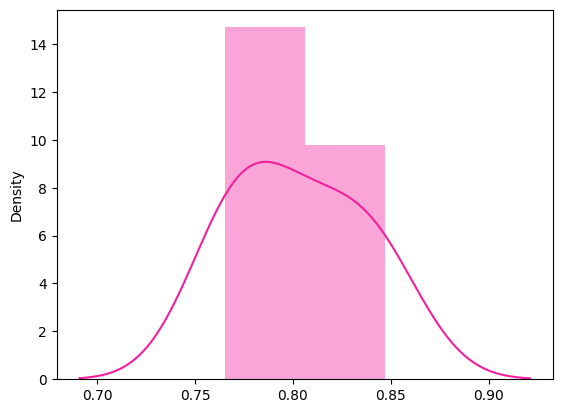

In [227]:
cv_score_rl = cross_val_score(rl, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=1)
sns.distplot(cv_score_rl, color='#f2209c')
plt.savefig('Xval_logreg.png', bbox_inches='tight')

In [228]:
# Entrenamiento del modelo
rl.fit(X_train, y_train) 

LogisticRegression(max_iter=250, penalty=None)

In [229]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=rl.predict(X_train) # Prediccion sobre el train
y_pred_test=rl.predict(X_test) # Prediccion sobre el test

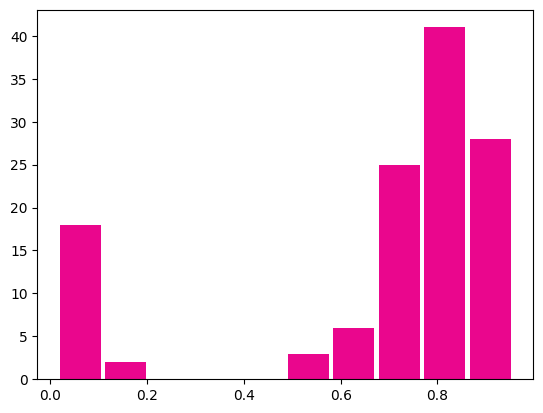

In [230]:
# Calculando probabilidades del modelo
prob_test_rl = rl.predict_proba(X_test)[:,1]
plt.hist(prob_test_rl, color = '#ea068d', rwidth=0.9)
plt.savefig('Probabilidades_logreg.png', bbox_inches='tight')

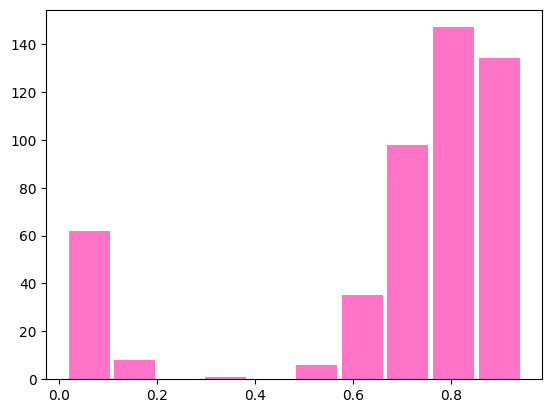

In [231]:
# Calculando las probabilidades para la muestra de entrenamiento
prob_train_rl = rl.predict_proba(X_train)[:,1]
plt.hist(prob_train_rl, color = '#ff74c6', rwidth=0.9)
plt.savefig('Probabilidades_train_logreg.png', bbox_inches='tight')

### Evaluación del Modelo

#### Matriz de Confusión

In [232]:
## Funciones
def print_mc(matriz_conf):
    matriz_conf = pd.DataFrame(matriz_conf)
    matriz_conf.index = ["Real_0","Real_1"]
    matriz_conf.columns = ["Pred_0","Pred_1"]
    print(matriz_conf)
    
def fx_evaluate_classif(y_real, pred, pred_proba):
    from sklearn import metrics as mt
    matriz_conf = mt.confusion_matrix(y_real,pred)
    print_mc(matriz_conf)
    roc = mt.roc_auc_score(y_real,pred_proba)
    accuracy_real = mt.accuracy_score(y_real,pred)
    print("\nROC: ", roc) 
    print("Accu:", accuracy_real,'\n')
    print(mt.classification_report(y_real, pred)[0:163])

In [233]:
print("Metricas del Testing..." + "\n")
fx_evaluate_classif(y_test, y_pred_test, prob_test_rl)

Metricas del Testing...

        Pred_0  Pred_1
Real_0      17      21
Real_1       3      82

ROC:  0.7337461300309597
Accu: 0.8048780487804879 

              precision    recall  f1-score   support

           0       0.85      0.45      0.59        38
           1       0.80      0.96      0.87        85



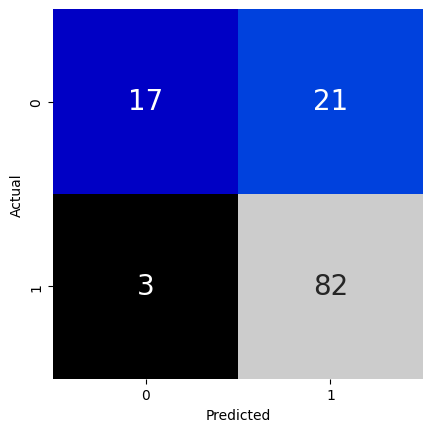

In [234]:
mat_logreg = confusion_matrix(y_test, y_pred_test)
sns.heatmap(mat_logreg, annot=True, fmt='d',cmap='nipy_spectral', square=True, cbar=False, annot_kws = {'size' : 20})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Confusion_matrix_logreg.png', bbox_inches='tight')

#### Curva de ROC

In [235]:
## AUC: Area bajo la curva
auc_rl = metrics.roc_auc_score(y_test, prob_test_rl)
auc_rl

0.7337461300309597

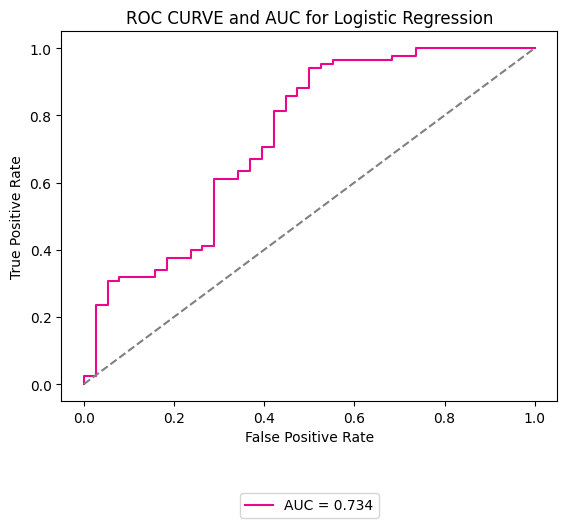

In [236]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_test_rl)
plt.plot(fpr, tpr, label= "AUC = " + str(auc_rl.round(3)), color='#ea068d')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC CURVE and AUC for Logistic Regression')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(.5,-0.23), loc='upper center')
plt.savefig('ROC_CURVES_logreg.png', bbox_inches='tight')

### Resultados del Modelo

In [237]:
# Asignamos las probabilidades a los datos transformados
probabilidad = list(prob_test_rl.round(3))
probabilidad_train = list(prob_train_rl.round(3))
X_test['PROBABILIDAD'] = probabilidad
X_train['PROBABILIDAD'] = probabilidad_train

In [238]:
# Ordenamos de mayor a menor las probabilidades
X_train = X_train.sort_values(['PROBABILIDAD'], ascending=False)
X_test = X_test.sort_values(['PROBABILIDAD'], ascending=False)

In [239]:
# Creamos grupos de probabilidad para la muestra de entrenamiento
X_train['GRUPOS'] = pd.qcut(X_train['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [240]:
# Creamos grupos de probabilidad para la muestra de validación
X_test['GRUPOS'] = pd.qcut(X_test['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [241]:
# Añadimos los identificadores de clientes
final_train = X_train.merge(df_index, how='left', left_index=True, right_index=True, sort=False)
final_test = X_test.merge(df_index, how='left', left_index=True, right_index=True, sort=False)

In [242]:
# Creamos una tabla resumen para la muestra de entrenamiento, donde debe mostrarse:
# - La distribución por grupos del modelo
# - La probabilidad mínima, media y máxima de cada grupo
# - Comparamos con la respuesta real de la muestra
resumen_train = final_train.groupby('GRUPOS')['PROBABILIDAD'].agg(['count','min','max','mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
ventas_train = final_train.groupby('GRUPOS')['Target'].agg(['sum', 'min', 'max', 'mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
resumen_train = pd.merge(resumen_train, ventas_train[['sum','mean']], left_index=True, right_index=True)
resumen_train.rename(columns={'count' : 'Leads', 'min' : 'Min', 'max': 'Max', 'sum': 'Préstamo', 'mean_x' : '%RR (Estimado)', 'mean_y' : '%RR (Real)'}, inplace = True)
resumen_train.to_excel(path_file + '\Resultados_train_RegLog.xlsx', index = False)
resumen_train

,GRUPOS,Leads,Min,Max,%RR (Estimado),Préstamo,%RR (Real)
9,1,45,0.905,0.945,0.917067,43,0.955556
8,2,51,0.874,0.904,0.891000,46,0.901961
7,3,51,0.838,0.873,0.858333,42,0.823529
6,4,49,0.809,0.837,0.822490,39,0.795918
5,5,49,0.782,0.808,0.795020,41,0.836735
4,6,49,0.741,0.781,0.765306,32,0.653061
3,7,49,0.704,0.739,0.718143,39,0.795918
2,8,49,0.642,0.703,0.678531,35,0.714286
1,9,49,0.071,0.640,0.393592,17,0.346939
0,10,50,0.014,0.067,0.040540,3,0.060000


In [243]:
# Creamos una tabla resumen para la muestra de validación, donde debe mostrarse:
# - La distribución por grupos del modelo
# - La probabilidad mínima, media y máxima de cada grupo
# - Comparamos con la respuesta real de la muestra
resumen_test = final_test.groupby('GRUPOS')['PROBABILIDAD'].agg(['count','min','max','mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
ventas_test = final_test.groupby('GRUPOS')['Target'].agg(['sum', 'min', 'max', 'mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
resumen_test = pd.merge(resumen_test, ventas_test[['sum','mean']], left_index=True, right_index=True)
resumen_test.rename(columns={'count' : 'Leads', 'min' : 'Min', 'max': 'Max', 'sum': 'Préstamo', 'mean_x' : '%RR (Estimado)', 'mean_y' : '%RR (Real)'}, inplace = True)
resumen_test.to_excel(path_file + '\Resultados_test_RegLog.xlsx', index = False)
resumen_test

,GRUPOS,Leads,Min,Max,%RR (Estimado),Préstamo,%RR (Real)
9,1,13,0.902,0.956,0.919077,12,0.923077
8,2,12,0.870,0.901,0.886667,11,0.916667
7,3,12,0.852,0.869,0.859667,7,0.583333
6,4,12,0.830,0.848,0.840750,8,0.666667
5,5,12,0.796,0.826,0.812083,12,1.000000
4,6,13,0.749,0.794,0.773000,9,0.692308
3,7,12,0.712,0.745,0.724917,10,0.833333
2,8,12,0.641,0.710,0.683000,10,0.833333
1,9,12,0.061,0.639,0.290000,4,0.333333
0,10,13,0.015,0.054,0.041000,2,0.153846


### Buen Trabajo!